# Analysis of Hanson's experimental results

## Contents

1. [Set-up](#Set-up)
1. [Results DataFrame](#Results-DataFrame)
1. [Listener accuracy broken down by distractor size](#Listener-accuracy-broken-down-by-distractor-size)
1. [The role of alpha for the incremental S1](#The-role-of-alpha-for-the-incremental-S1)
1. [ROUGE scoring](#ROUGE-scoring)

## Set-up

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use("ggplot")

## Results DataFrame

Filter out unwanted search ranges, restrict to the colummns with diverse values to make inspection easier:

In [42]:
df_orig = pd.read_csv("../memo_l1_res.csv")
df = df_orig
df = df[(df['bert_distr_repl_search_top'] == 5) & (df['bert_distr_exclusion_set'] == 3)
        & (df['prag_alpha'] >= 1.) 
        & (df['prag_alpha'] <= 2) 
        & (df['pragmatics'] != 'growing_alpha')
        & (df['pragmatics'] != 'growing_alpha_p1')].copy()

# cols = ['mode', 'pragmatics', 'prag_alpha', 'beam_size', 'bert_distr_d_factor', 'listener_acc', 'METEOR']

# df = df[cols].copy()

In [124]:
df.head()

,id,gpu,random_seed,dummy_src,distractor,pragmatics,mode,batch_size,shard_size,truncate,...,rouge_1r,rouge_1p,rouge_1f,rouge_2r,rouge_2p,rouge_2f,rouge_lr,rouge_lp,rouge_lf,METEOR
5,7,1,39831,data/giga_small_input.txt,bert,basic,incr_s1,32,2000,-1,...,0.424617,0.500120,0.448130,0.22265,0.259447,0.233022,0.401015,0.471866,0.423142,0.210159
7,9,1,39831,data/giga_small_input.txt,bert,basic,incr_s1,32,2000,-1,...,0.424246,0.497421,0.446776,0.22179,0.257414,0.231614,0.400084,0.468691,0.421265,0.209698
9,11,1,39831,data/giga_small_input.txt,bert,basic,incr_s1,32,2000,-1,...,0.424585,0.495347,0.445977,0.22134,0.255393,0.230549,0.399987,0.466506,0.420213,0.209713
45,47,1,39831,data/giga_small_input.txt,bert,basic,incr_s1,32,2000,-1,...,0.422998,0.490307,0.443116,0.21976,0.251482,0.228172,0.397718,0.461026,0.416729,0.208122
47,49,1,39831,data/giga_small_input.txt,bert,basic,incr_s1,32,2000,-1,...,0.418983,0.483984,0.438205,0.21786,0.248578,0.225853,0.394765,0.455563,0.412787,0.206628


## Calculate harmonic mean between listener accuracy and METEOR, add column

In [130]:
accs = df['listener_acc'].values
meteors = df['METEOR'].values
harmonic_mean = 2. / (1./accs + 1./meteors)
df['acc_METEOR_mean'] = harmonic_mean


## Listener accuracy broken down by distractor size

The numbers here look like a clear argument for the incremental S1. 

* Fingers crossed on this holding for `bert_distr_d_factor=10` as well!
* Would it be better to do the average rather than the max? Or maybe the average of the runs with the best `prag_alpha`?

In [44]:
def get_listener_accuracy_by_distractor(df):
    return pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values='listener_acc',
        aggfunc='max')

In [45]:
get_listener_accuracy_by_distractor(df)

mode,incr_s1,s0
bert_distr_d_factor,,
2,0.631709,0.557361
5,0.412605,0.353028
10,0.339242,0.266371


Here you can start to see that the S1 advantage is likely bigger for larger distractor sets:

In [46]:
def plot_listener_accuracy_by_distractor(df):
    pt = get_listener_accuracy_by_distractor(df)
    ax = pt.plot()
    ax.set_ylabel('listener_acc')
    ax.set_xticks(df['bert_distr_d_factor'].unique())

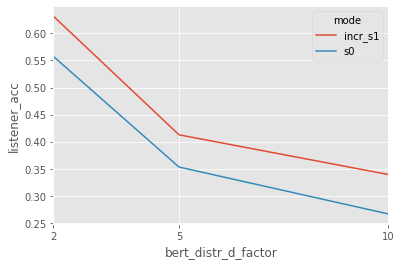

In [47]:
plot_listener_accuracy_by_distractor(df)

## The role of alpha for the incremental S1

It looks like higher alpha consistently leads to higher accuracy, even for the simpler two-distractor setting.

In [48]:
def plot_accuracy_by_alpha_for_s1(df, prag):
    s1_df = df[(df['mode'] == 'incr_s1') & (df['pragmatics'] == prag)]
    s1_df_acc = pd.pivot_table(
        s1_df, 
        index='prag_alpha', 
        columns='bert_distr_d_factor', 
        values='listener_acc')
    ax = s1_df_acc.plot()
    ax.set_ylabel('listener_acc')
    ax.set_xticks(s1_df['prag_alpha'].unique())
    return ax

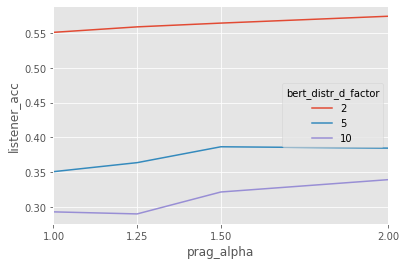

In [49]:
_ = plot_accuracy_by_alpha_for_s1(df, 'basic')

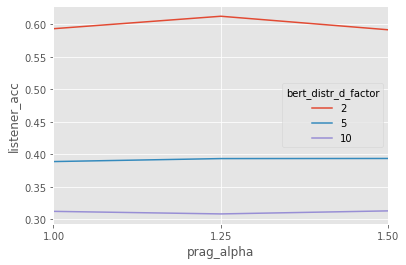

In [50]:
_ = plot_accuracy_by_alpha_for_s1(df, 'memoized_l1')

## Comparison between basic and memoized L1 - listener acc

Observations:

For 2 and 5 distractors, memoized l1 has an advantage over basic in terms of listener accuracy over various values of alpha.

In [51]:
def get_listener_accuracy_by_pragmatics(df):
    return pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='pragmatics', 
        values='listener_acc',
        aggfunc='max')

In [52]:
get_listener_accuracy_by_distractor(df)

mode,incr_s1,s0
bert_distr_d_factor,,
2,0.631709,0.557361
5,0.412605,0.353028
10,0.339242,0.266371


In [53]:
get_listener_accuracy_by_pragmatics(df)

pragmatics,basic,memoized_l1
bert_distr_d_factor,,
2,0.574101,0.631709
5,0.398326,0.412605
10,0.339242,0.317085


In [108]:
def plot_metric_by_param_for_pragmatics(df, metric, param):
    s1_df = df[(df['mode'] == 'incr_s1')]
    s1_df_acc = pd.pivot_table(
        s1_df, 
        index=param, 
        columns='pragmatics', 
        values=metric,
        aggfunc='max')
    ax = s1_df_acc.plot()
    ax.set_ylabel(metric)
    ax.set_xticks(s1_df[param].unique())
    return ax

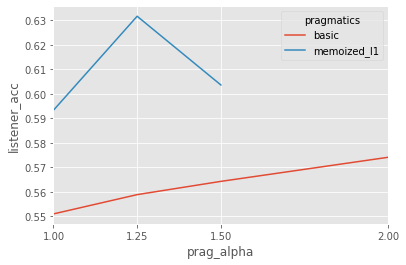

In [131]:
# for 1 distractor
one_df = df[df['bert_distr_d_factor'] == 2]
plot_metric_by_param_for_pragmatics(one_df, metric='listener_acc', param='prag_alpha')

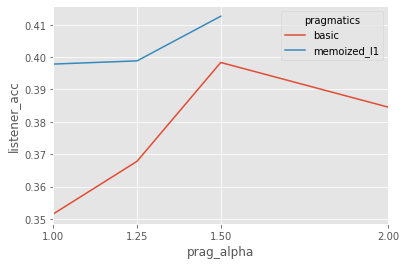

In [132]:
# for 4 distractors
four_df = df[df['bert_distr_d_factor'] == 5].copy()
plot_metric_by_param_for_pragmatics(four_df, metric='listener_acc', param='prag_alpha')

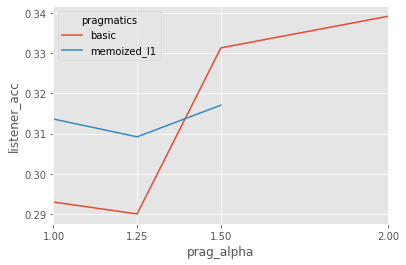

In [133]:
# for 9 distractors
nine_df = df[df['bert_distr_d_factor'] == 10].copy()
plot_metric_by_param_for_pragmatics(nine_df, metric='listener_acc', param='prag_alpha')

## Comparison between basic and memoized L1 - METEOR

In [71]:
def get_meteor_by_pragmatics(df):
    return pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='pragmatics', 
        values='METEOR',
        aggfunc='max')

In [73]:
get_meteor_by_pragmatics(df[df['mode']=='incr_s1'])

pragmatics,basic,memoized_l1
bert_distr_d_factor,,
2,0.210159,0.210304
5,0.208122,0.210050
10,0.205691,0.208579


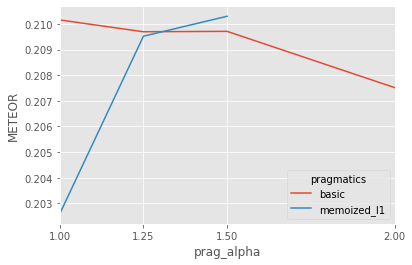

In [114]:
# for 1 distractor
plot_metric_by_param_for_pragmatics(one_df, metric='METEOR', param='prag_alpha')

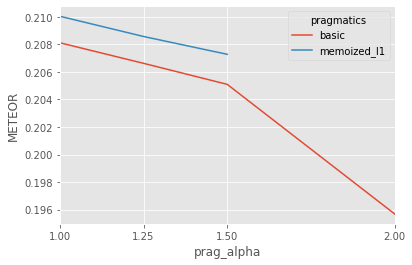

In [115]:
# for 4 distractors
plot_metric_by_param_for_pragmatics(four_df, metric='METEOR', param='prag_alpha')

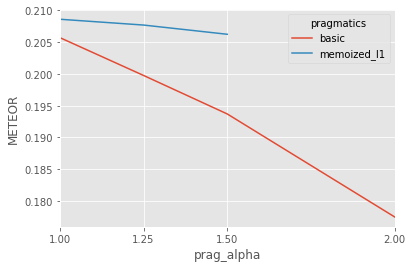

In [116]:
# for 9 distractors
plot_metric_by_param_for_pragmatics(nine_df, metric='METEOR', param='prag_alpha')

## Comparison between basic and memoized L1 - acc-METEOR harmonic mean

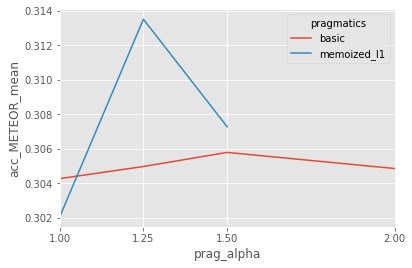

In [134]:
plot_metric_by_param_for_pragmatics(one_df, metric='acc_METEOR_mean', param='prag_alpha')

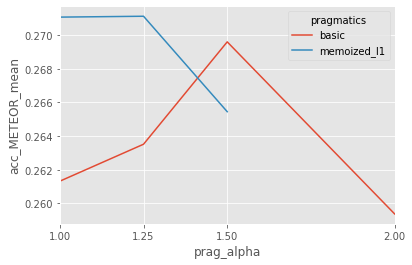

In [135]:
plot_metric_by_param_for_pragmatics(four_df, metric='acc_METEOR_mean', param='prag_alpha')

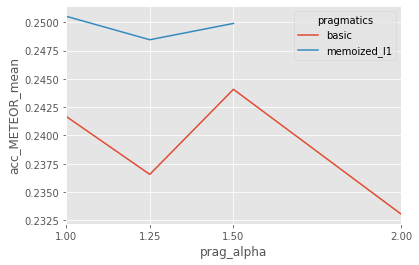

In [136]:
plot_metric_by_param_for_pragmatics(nine_df, metric='acc_METEOR_mean', param='prag_alpha')

## Effect of beam size on different pragmatics

Effect of beam size on listener accuracy

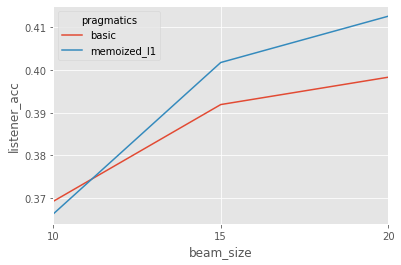

In [119]:
# Fix alpha=1.5, num distractors=4, 
testdf = df[(df['prag_alpha'] == 1.5) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='listener_acc', param='beam_size')

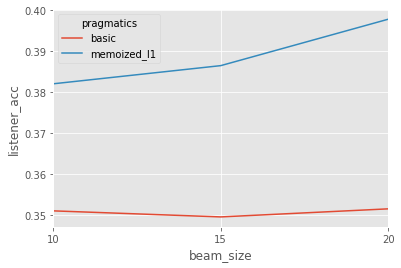

In [121]:
# Fix alpha=1, num distractors=4, `
testdf = df[(df['prag_alpha'] == 1) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='listener_acc', param='beam_size')

Effect of beam size on METEOR

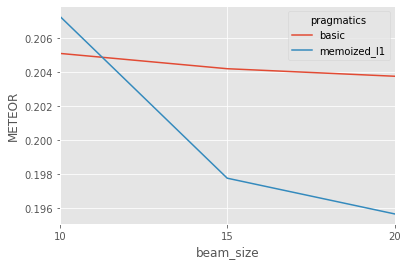

In [122]:
testdf = df[(df['prag_alpha'] == 1.5) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='METEOR', param='beam_size')

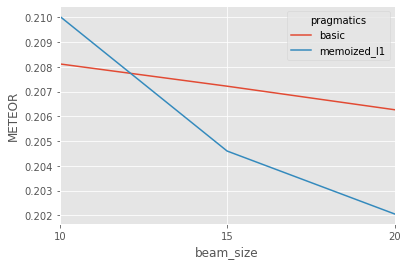

In [123]:
testdf = df[(df['prag_alpha'] == 1) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='METEObR', param='beam_size')

Effect of beam size on harmonic mean

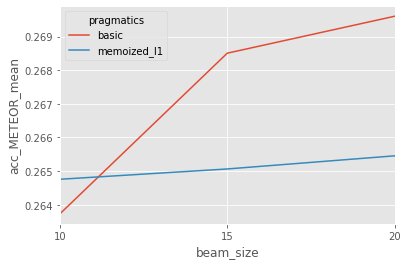

In [137]:
testdf = df[(df['prag_alpha'] == 1.5) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='acc_METEOR_mean', param='beam_size')

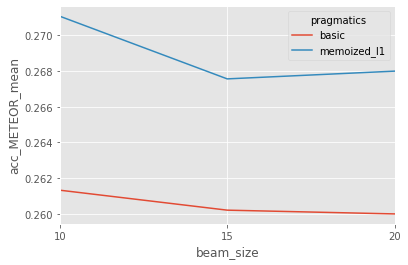

In [138]:
testdf = df[(df['prag_alpha'] == 1) & (df['bert_distr_d_factor'] == 5)]
plot_metric_by_param_for_pragmatics(testdf, metric='acc_METEOR_mean', param='beam_size')

## ROUGE scoring

The pragmatic model is not ahead here, but I am not sure how surprised we should be by that given the values encoded by ROUGE.

In [57]:
def get_rouge_by_distractor(df, rouge_type):
    rouge_col = "rouge_{}".format(rouge_type)
    pt = pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values=rouge_col,
        aggfunc='max')
    # Format for faster quick comparisons:
    return (pt * 100).round(3)

In [58]:
get_rouge_by_distractor(df, '1f')

mode,incr_s1,s0
bert_distr_d_factor,,
2,45.025,45.066
5,44.934,45.066
10,44.627,45.066


In [59]:
get_rouge_by_distractor(df, '2f')

mode,incr_s1,s0
bert_distr_d_factor,,
2,23.514,23.532
5,23.590,23.532
10,23.468,23.532


In [60]:
get_rouge_by_distractor(df, 'lf')

mode,incr_s1,s0
bert_distr_d_factor,,
2,42.554,42.619
5,42.502,42.619
10,42.146,42.619


## METEOR scoring

In [61]:
def get_meteor_by_distractor(df, aggfunc):
    pt = pd.pivot_table(
        df, 
        index='bert_distr_d_factor', 
        columns='mode', 
        values='METEOR',
        aggfunc=aggfunc)
    # Format for faster quick comparisons:
    return (pt * 100).round(3)

In [62]:
get_meteor_by_distractor(df, 'max')

mode,incr_s1,s0
bert_distr_d_factor,,
2,21.030,20.968
5,21.005,20.968
10,20.858,20.968
